# CMS Open Data $t\bar{t}$: from data delivery to statistical inference

We are using [2015 CMS Open Data](https://cms.cern/news/first-cms-open-data-lhc-run-2-released) in this demonstration to showcase an analysis pipeline.
It features data delivery and processing, histogram construction and visualization, as well as statistical inference.

This notebook was developed in the context of the [IRIS-HEP AGC tools 2022 workshop](https://indico.cern.ch/e/agc-tools-2).
This work was supported by the U.S. National Science Foundation (NSF) Cooperative Agreement OAC-1836650 (IRIS-HEP).

This is a **technical demonstration**.
We are including the relevant workflow aspects that physicists need in their work, but we are not focusing on making every piece of the demonstration physically meaningful.
This concerns in particular systematic uncertainties: we capture the workflow, but the actual implementations are more complex in practice.
If you are interested in the physics side of analyzing top pair production, check out the latest results from [ATLAS](https://twiki.cern.ch/twiki/bin/view/AtlasPublic/TopPublicResults) and [CMS](https://cms-results.web.cern.ch/cms-results/public-results/preliminary-results/)!
If you would like to see more technical demonstrations, also check out an [ATLAS Open Data example](https://indico.cern.ch/event/1076231/contributions/4560405/) demonstrated previously.

This notebook implements most of the analysis pipeline shown in the following picture, using the tools also mentioned there:
![ecosystem visualization](utils/ecosystem.png)

### Data pipelines

There are two possible pipelines: one with `ServiceX` enabled, and one using only `coffea` for processing.
![processing pipelines](utils/processing_pipelines.png)

### Imports: setting up our environment

In [1]:
import logging
import time

import awkward as ak
import cabinetry
import cloudpickle
import correctionlib
from coffea import processor
from coffea.nanoevents import NanoAODSchema
from coffea.analysis_tools import PackedSelection
import copy
from func_adl import ObjectStream
from func_adl_servicex import ServiceXSourceUpROOT
import hist
import matplotlib.pyplot as plt
import numpy as np
import pyhf

import utils  # contains code for bookkeeping and cosmetics, as well as some boilerplate

logging.getLogger("cabinetry").setLevel(logging.INFO)

### Configuration: number of files and data delivery path

The number of files per sample set here determines the size of the dataset we are processing. There are 9 samples being used here, all part of the 2015 CMS Open Data release.

These samples were originally published in miniAOD format, but for the purposes of this demonstration were pre-converted into nanoAOD format. More details about the inputs can be found [here](https://github.com/iris-hep/analysis-grand-challenge/tree/main/datasets/cms-open-data-2015).

The table below summarizes the amount of data processed depending on the `N_FILES_MAX_PER_SAMPLE` setting.

| setting | number of files | total size | number of events |
| --- | --- | --- | --- |
| `1` | 9 | 22.9 GB | 10,455,719 |
| `2` | 18 | 42.8 GB | 19,497,435 |
| `5` | 43 | 105 GB | 47,996,231 |
| `10` | 79 | 200 GB | 90,546,458 |
| `20` | 140 | 359 GB | 163,123,242 |
| `50` | 255 | 631 GB | 297,247,463 |
| `100` | 395 | 960 GB | 470,397,795 |
| `200` | 595 | 1.40 TB | 705,273,291 |
| `-1` | 787 | 1.78 TB | 940,160,174 |

The input files are all in the 1–3 GB range.

In [2]:
### GLOBAL CONFIGURATION
# input files per process, set to e.g. 10 (smaller number = faster)
N_FILES_MAX_PER_SAMPLE = 5

# enable Dask
USE_DASK = True

# enable ServiceX
USE_SERVICEX = False

### ML-INFERENCE SETTINGS

# enable ML inference
USE_INFERENCE = True

# enable inference using NVIDIA Triton server
USE_TRITON = False

### Defining our `coffea` Processor

The processor includes a lot of the physics analysis details:
- event filtering and the calculation of observables,
- event weighting,
- calculating systematic uncertainties at the event and object level,
- filling all the information into histograms that get aggregated and ultimately returned to us by `coffea`.

#### Machine Learning Task

During the processing step, machine learning is used to calculate one of the variables used for this analysis. The models used are trained separately in the `jetassignment_training.ipynb` notebook. Jets in the events are assigned to labels corresponding with their parent partons using a boosted decision tree (BDT). More information about the model and training can be found within that notebook.

In [3]:
class TtbarAnalysis(processor.ProcessorABC):
    def __init__(self, use_inference, use_triton):

        # initialize dictionary of hists for signal and control region
        self.hist_dict = {}
        for region in ["4j1b", "4j2b"]:
            self.hist_dict[region] = (
                hist.Hist.new.Reg(utils.config["global"]["NUM_BINS"], 
                                  utils.config["global"]["BIN_LOW"], 
                                  utils.config["global"]["BIN_HIGH"], 
                                  name="observable", 
                                  label="observable [GeV]")
                .StrCat([], name="process", label="Process", growth=True)
                .StrCat([], name="variation", label="Systematic variation", growth=True)
                .Weight()
            )
        
        self.cset = correctionlib.CorrectionSet.from_file("corrections.json")
        self.use_inference = use_inference
        
        # set up attributes only needed if USE_INFERENCE=True
        if self.use_inference:
            
            # initialize dictionary of hists for ML observables
            self.ml_hist_dict = {}
            for i in range(len(utils.config["ml"]["FEATURE_NAMES"])):
                self.ml_hist_dict[utils.config["ml"]["FEATURE_NAMES"][i]] = (
                    hist.Hist.new.Reg(utils.config["global"]["NUM_BINS"],
                                      utils.config["ml"]["BIN_LOW"][i],
                                      utils.config["ml"]["BIN_HIGH"][i],
                                      name="observable",
                                      label=utils.config["ml"]["FEATURE_DESCRIPTIONS"][i])
                    .StrCat([], name="process", label="Process", growth=True)
                    .StrCat([], name="variation", label="Systematic variation", growth=True)
                    .Weight()
                )
            
            self.use_triton = use_triton

    def only_do_IO(self, events):
        for branch in utils.config["benchmarking"]["IO_BRANCHES"][
            utils.config["benchmarking"]["IO_FILE_PERCENT"]
        ]:
            if "_" in branch:
                split = branch.split("_")
                object_type = split[0]
                property_name = "_".join(split[1:])
                ak.materialized(events[object_type][property_name])
            else:
                ak.materialized(events[branch])
        return {"hist": {}}

    def process(self, events):
        if utils.config["benchmarking"]["DISABLE_PROCESSING"]:
            # IO testing with no subsequent processing
            return self.only_do_IO(events)

        # create copies of histogram objects
        hist_dict = copy.deepcopy(self.hist_dict)
        if self.use_inference:
            ml_hist_dict = copy.deepcopy(self.ml_hist_dict)

        process = events.metadata["process"]  # "ttbar" etc.
        variation = events.metadata["variation"]  # "nominal" etc.

        # normalization for MC
        x_sec = events.metadata["xsec"]
        nevts_total = events.metadata["nevts"]
        lumi = 3378 # /pb
        if process != "data":
            xsec_weight = x_sec * lumi / nevts_total
        else:
            xsec_weight = 1

        # setup triton gRPC client
        if self.use_inference and self.use_triton:
            triton_client = utils.clients.get_triton_client(utils.config["ml"]["TRITON_URL"])


        #### systematics
        # jet energy scale / resolution systematics
        # need to adjust schema to instead use coffea add_systematic feature, especially for ServiceX
        # cannot attach pT variations to events.jet, so attach to events directly
        # and subsequently scale pT by these scale factors
        events["pt_scale_up"] = 1.03
        events["pt_res_up"] = utils.systematics.jet_pt_resolution(events.Jet.pt)

        syst_variations = ["nominal"]
        jet_kinematic_systs = ["pt_scale_up", "pt_res_up"]
        event_systs = [f"btag_var_{i}" for i in range(4)]
        if process == "wjets":
            event_systs.append("scale_var")

        # Only do systematics for nominal samples, e.g. ttbar__nominal
        if variation == "nominal":
            syst_variations.extend(jet_kinematic_systs)
            syst_variations.extend(event_systs)

        # for pt_var in pt_variations:
        for syst_var in syst_variations:
            ### event selection
            # very very loosely based on https://arxiv.org/abs/2006.13076

            # Note: This creates new objects, distinct from those in the 'events' object
            elecs = events.Electron
            muons = events.Muon
            jets = events.Jet
            if syst_var in jet_kinematic_systs:
                # Replace jet.pt with the adjusted values
                jets["pt"] = jets.pt * events[syst_var]

            electron_reqs = (elecs.pt > 30) & (np.abs(elecs.eta) < 2.1) & (elecs.cutBased == 4) & (elecs.sip3d < 4)
            muon_reqs = ((muons.pt > 30) & (np.abs(muons.eta) < 2.1) & (muons.tightId) & (muons.sip3d < 4) &
                         (muons.pfRelIso04_all < 0.15))
            jet_reqs = (jets.pt > 30) & (np.abs(jets.eta) < 2.4) & (jets.isTightLeptonVeto)

            # Only keep objects that pass our requirements
            elecs = elecs[electron_reqs]
            muons = muons[muon_reqs]
            jets = jets[jet_reqs]

            if self.use_inference:
                even = (events.event%2==0)  # whether events are even/odd

            B_TAG_THRESHOLD = 0.5

            ######### Store boolean masks with PackedSelection ##########
            selections = PackedSelection(dtype='uint64')
            # Basic selection criteria
            selections.add("exactly_1l", (ak.num(elecs) + ak.num(muons)) == 1)
            selections.add("atleast_4j", ak.num(jets) >= 4)
            selections.add("exactly_1b", ak.sum(jets.btagCSVV2 > B_TAG_THRESHOLD, axis=1) == 1)
            selections.add("atleast_2b", ak.sum(jets.btagCSVV2 > B_TAG_THRESHOLD, axis=1) >= 2)
            # Complex selection criteria
            selections.add("4j1b", selections.all("exactly_1l", "atleast_4j", "exactly_1b"))
            selections.add("4j2b", selections.all("exactly_1l", "atleast_4j", "atleast_2b"))

            for region in ["4j1b", "4j2b"]:
                region_selection = selections.all(region)
                region_jets = jets[region_selection]
                region_elecs = elecs[region_selection]
                region_muons = muons[region_selection]
                region_weights = np.ones(len(region_jets)) * xsec_weight
                if self.use_inference:
                    region_even = even[region_selection]

                if region == "4j1b":
                    observable = ak.sum(region_jets.pt, axis=-1)

                elif region == "4j2b":

                    # reconstruct hadronic top as bjj system with largest pT
                    trijet = ak.combinations(region_jets, 3, fields=["j1", "j2", "j3"])  # trijet candidates
                    trijet["p4"] = trijet.j1 + trijet.j2 + trijet.j3  # calculate four-momentum of tri-jet system
                    trijet["max_btag"] = np.maximum(trijet.j1.btagCSVV2, np.maximum(trijet.j2.btagCSVV2, trijet.j3.btagCSVV2))
                    trijet = trijet[trijet.max_btag > B_TAG_THRESHOLD]  # at least one-btag in trijet candidates
                    # pick trijet candidate with largest pT and calculate mass of system
                    trijet_mass = trijet["p4"][ak.argmax(trijet.p4.pt, axis=1, keepdims=True)].mass
                    observable = ak.flatten(trijet_mass)

                    if sum(region_selection)==0:
                        continue

                    if self.use_inference:
                        features, perm_counts = utils.ml.get_features(
                            region_jets,
                            region_elecs,
                            region_muons,
                            max_n_jets=utils.config["ml"]["MAX_N_JETS"],
                        )
                        even_perm = np.repeat(region_even, perm_counts)

                        # calculate ml observable
                        if self.use_triton:
                            results = utils.ml.get_inference_results_triton(
                                features,
                                even_perm,
                                triton_client,
                                utils.config["ml"]["MODEL_NAME"],
                                utils.config["ml"]["MODEL_VERSION_EVEN"],
                                utils.config["ml"]["MODEL_VERSION_ODD"],
                            )

                        else:
                            results = utils.ml.get_inference_results_local(
                                features,
                                even_perm,
                                utils.ml.model_even,
                                utils.ml.model_odd,
                            )
                            
                        results = ak.unflatten(results, perm_counts)
                        features = ak.flatten(ak.unflatten(features, perm_counts)[
                            ak.from_regular(ak.argmax(results,axis=1)[:, np.newaxis])
                        ])
                syst_var_name = f"{syst_var}"
                # Break up the filling into event weight systematics and object variation systematics
                if syst_var in event_systs:
                    for i_dir, direction in enumerate(["up", "down"]):
                        # Should be an event weight systematic with an up/down variation
                        if syst_var.startswith("btag_var"):
                            i_jet = int(syst_var.rsplit("_",1)[-1])   # Kind of fragile
                            wgt_variation = self.cset["event_systematics"].evaluate("btag_var", direction, region_jets.pt[:,i_jet])
                        elif syst_var == "scale_var":
                            # The pt array is only used to make sure the output array has the correct shape
                            wgt_variation = self.cset["event_systematics"].evaluate("scale_var", direction, region_jets.pt[:,0])
                        syst_var_name = f"{syst_var}_{direction}"
                        hist_dict[region].fill(
                            observable=observable, process=process,
                            variation=syst_var_name, weight=region_weights * wgt_variation
                        )
                        if region == "4j2b" and self.use_inference:
                            for i in range(len(utils.config["ml"]["FEATURE_NAMES"])):
                                ml_hist_dict[utils.config["ml"]["FEATURE_NAMES"][i]].fill(
                                    observable=features[..., i], process=process,
                                    variation=syst_var_name, weight=region_weights * wgt_variation
                                )
                else:
                    # Should either be 'nominal' or an object variation systematic
                    if variation != "nominal":
                        # This is a 2-point systematic, e.g. ttbar__scaledown, ttbar__ME_var, etc.
                        syst_var_name = variation
                    hist_dict[region].fill(
                        observable=observable, process=process,
                        variation=syst_var_name, weight=region_weights
                    )
                    if region == "4j2b" and self.use_inference:
                        for i in range(len(utils.config["ml"]["FEATURE_NAMES"])):
                            ml_hist_dict[utils.config["ml"]["FEATURE_NAMES"][i]].fill(
                                observable=features[..., i], process=process,
                                variation=syst_var_name, weight=region_weights
                            )


        output = {"nevents": {events.metadata["dataset"]: len(events)}, "hist_dict": hist_dict}
        if self.use_inference:
            output["ml_hist_dict"] = ml_hist_dict

        return output

    def postprocess(self, accumulator):
        return accumulator

### "Fileset" construction and metadata

Here, we gather all the required information about the files we want to process: paths to the files and asociated metadata.

In [4]:
fileset = utils.file_input.construct_fileset(
    N_FILES_MAX_PER_SAMPLE,
    use_xcache=False,
    af_name=utils.config["benchmarking"]["AF_NAME"],  # local files on /data for af_name="ssl-dev"
    input_from_eos=utils.config["benchmarking"]["INPUT_FROM_EOS"],
    xcache_atlas_prefix=utils.config["benchmarking"]["XCACHE_ATLAS_PREFIX"],
)

print(f"processes in fileset: {list(fileset.keys())}")
print(f"\nexample of information in fileset:\n{{\n  'files': [{fileset['ttbar__nominal']['files'][0]}, ...],")
print(f"  'metadata': {fileset['ttbar__nominal']['metadata']}\n}}")

processes in fileset: ['ttbar__nominal', 'ttbar__scaledown', 'ttbar__scaleup', 'ttbar__ME_var', 'ttbar__PS_var', 'single_top_s_chan__nominal', 'single_top_t_chan__nominal', 'single_top_tW__nominal', 'wjets__nominal']

example of information in fileset:
{
  'files': [https://xrootd-local.unl.edu:1094//store/user/AGC/nanoAOD/TT_TuneCUETP8M1_13TeV-powheg-pythia8/cmsopendata2015_ttbar_19980_PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1_00000_0000.root, ...],
  'metadata': {'process': 'ttbar', 'variation': 'nominal', 'nevts': 6389801, 'xsec': 729.84}
}


### ServiceX-specific functionality: query setup

Define the func_adl query to be used for the purpose of extracting columns and filtering.

In [5]:
def get_query(source: ObjectStream) -> ObjectStream:
    """Query for event / column selection: >=4j >=1b, ==1 lep with pT>30 GeV + additional cuts,
    return relevant columns
    *NOTE* jet pT cut is set lower to account for systematic variations to jet pT
    """
    cuts = source.Where(lambda e: {"pt": e.Electron_pt,
                               "eta": e.Electron_eta,
                               "cutBased": e.Electron_cutBased,
                               "sip3d": e.Electron_sip3d,}.Zip()\
                        .Where(lambda electron: (electron.pt > 30
                                                 and abs(electron.eta) < 2.1
                                                 and electron.cutBased == 4
                                                 and electron.sip3d < 4)).Count()
                        + {"pt": e.Muon_pt,
                           "eta": e.Muon_eta,
                           "tightId": e.Muon_tightId,
                           "sip3d": e.Muon_sip3d,
                           "pfRelIso04_all": e.Muon_pfRelIso04_all}.Zip()\
                        .Where(lambda muon: (muon.pt > 30
                                             and abs(muon.eta) < 2.1
                                             and muon.tightId
                                             and muon.pfRelIso04_all < 0.15)).Count()== 1)\
                        .Where(lambda f: {"pt": f.Jet_pt,
                                          "eta": f.Jet_eta,
                                          "jetId": f.Jet_jetId}.Zip()\
                               .Where(lambda jet: (jet.pt > 25
                                                   and abs(jet.eta) < 2.4
                                                   and jet.jetId == 6)).Count() >= 4)\
                        .Where(lambda g: {"pt": g.Jet_pt,
                                          "eta": g.Jet_eta,
                                          "btagCSVV2": g.Jet_btagCSVV2,
                                          "jetId": g.Jet_jetId}.Zip()\
                        .Where(lambda jet: (jet.btagCSVV2 > 0.5
                                            and jet.pt > 25
                                            and abs(jet.eta) < 2.4)
                                            and jet.jetId == 6).Count() >= 1)
    selection = cuts.Select(lambda h: {"Electron_pt": h.Electron_pt,
                                       "Electron_eta": h.Electron_eta,
                                       "Electron_phi": h.Electron_phi,
                                       "Electron_mass": h.Electron_mass,
                                       "Electron_cutBased": h.Electron_cutBased,
                                       "Electron_sip3d": h.Electron_sip3d,
                                       "Muon_pt": h.Muon_pt,
                                       "Muon_eta": h.Muon_eta,
                                       "Muon_phi": h.Muon_phi,
                                       "Muon_mass": h.Muon_mass,
                                       "Muon_tightId": h.Muon_tightId,
                                       "Muon_sip3d": h.Muon_sip3d,
                                       "Muon_pfRelIso04_all": h.Muon_pfRelIso04_all,
                                       "Jet_mass": h.Jet_mass,
                                       "Jet_pt": h.Jet_pt,
                                       "Jet_eta": h.Jet_eta,
                                       "Jet_phi": h.Jet_phi,
                                       "Jet_qgl": h.Jet_qgl,
                                       "Jet_btagCSVV2": h.Jet_btagCSVV2,
                                       "Jet_jetId": h.Jet_jetId,
                                       "event": h.event,
                                      })
    if USE_INFERENCE:
        return selection

    # some branches are only needed if USE_INFERENCE is turned on
    return selection.Select(lambda h: {"Electron_pt": h.Electron_pt,
                                       "Electron_eta": h.Electron_eta,
                                       "Electron_cutBased": h.Electron_cutBased,
                                       "Electron_sip3d": h.Electron_sip3d,
                                       "Muon_pt": h.Muon_pt,
                                       "Muon_eta": h.Muon_eta,
                                       "Muon_tightId": h.Muon_tightId,
                                       "Muon_sip3d": h.Muon_sip3d,
                                       "Muon_pfRelIso04_all": h.Muon_pfRelIso04_all,
                                       "Jet_mass": h.Jet_mass,
                                       "Jet_pt": h.Jet_pt,
                                       "Jet_eta": h.Jet_eta,
                                       "Jet_phi": h.Jet_phi,
                                       "Jet_btagCSVV2": h.Jet_btagCSVV2,
                                       "Jet_jetId": h.Jet_jetId,
                                      })

### Caching the queried datasets with `ServiceX`

Using the queries created with `func_adl`, we are using `ServiceX` to read the CMS Open Data files to build cached files with only the specific event information as dictated by the query.

In [6]:
if USE_SERVICEX:
    # dummy dataset on which to generate the query
    dummy_ds = ServiceXSourceUpROOT("cernopendata://dummy", "Events", backend_name="uproot")

    # tell low-level infrastructure not to contact ServiceX yet, only to
    # return the qastle string it would have sent
    dummy_ds.return_qastle = True

    # create the query
    query = get_query(dummy_ds).value()

    # now we query the files using a wrapper around ServiceXDataset to transform all processes at once
    t0 = time.time()
    ds = utils.file_input.ServiceXDatasetGroup(fileset, backend_name="uproot", ignore_cache=utils.config["global"]["SERVICEX_IGNORE_CACHE"])
    files_per_process = ds.get_data_rootfiles_uri(query, as_signed_url=True, title="CMS ttbar")

    print(f"ServiceX data delivery took {time.time() - t0:.2f} seconds")

    # update fileset to point to ServiceX-transformed files
    for process in fileset.keys():
        fileset[process]["files"] = [f.url for f in files_per_process[process]]

### Execute the data delivery pipeline

What happens here depends on the flag `USE_SERVICEX`. If set to true, the processor is run on the data previously gathered by ServiceX, then will gather output histograms.

When `USE_SERVICEX` is false, the input files need to be processed during this step as well.

In [7]:
NanoAODSchema.warn_missing_crossrefs = False # silences warnings about branches we will not use here
if USE_DASK:
    cloudpickle.register_pickle_by_value(utils) # serialize methods and objects in utils so that they can be accessed within the coffea processor
    executor = processor.DaskExecutor(client=utils.clients.get_client(af=utils.config["global"]["AF"]))
else:
    executor = processor.FuturesExecutor(workers=utils.config["benchmarking"]["NUM_CORES"])

run = processor.Runner(
    executor=executor, 
    schema=NanoAODSchema, 
    savemetrics=True, 
    metadata_cache={}, 
    chunksize=utils.config["benchmarking"]["CHUNKSIZE"])

if USE_SERVICEX:
    treename = "servicex"

else:
    treename = "Events"

# load local models if not using Triton and models are not yet loaded
if USE_INFERENCE and not USE_TRITON and utils.ml.model_even is None and utils.ml.model_odd is None:
    utils.ml.load_models()

filemeta = run.preprocess(fileset, treename=treename)  # pre-processing

t0 = time.monotonic()
# processing
all_histograms, metrics = run(
    fileset, 
    treename, 
    processor_instance=TtbarAnalysis(USE_INFERENCE, USE_TRITON)
)
exec_time = time.monotonic() - t0

print(f"\nexecution took {exec_time:.2f} seconds")

/opt/conda/lib/python3.8/site-packages/distributed/client.py:1288: VersionMismatchWarning: Mismatched versions found

+---------+----------------+----------------+----------------+
| Package | client         | scheduler      | workers        |
+---------+----------------+----------------+----------------+
| python  | 3.8.16.final.0 | 3.8.16.final.0 | 3.8.15.final.0 |
+---------+----------------+----------------+----------------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


[########################################] | 100% Completed |  4min  6.7s
execution took 246.94 seconds


In [8]:
# track metrics
utils.metrics.track_metrics(metrics, fileset, exec_time, USE_DASK, USE_SERVICEX, N_FILES_MAX_PER_SAMPLE, USE_INFERENCE, USE_TRITON)

metrics saved as metrics/coffea_casa-20230905-190831.json
event rate per worker (pure processtime): 4.56 kHz
amount of data read: 14556.75 MB (note that this can be buggy: https://github.com/CoffeaTeam/coffea/issues/717)


### Inspecting the produced histograms

Let's have a look at the data we obtained.
We built histograms in two phase space regions, for multiple physics processes and systematic variations.

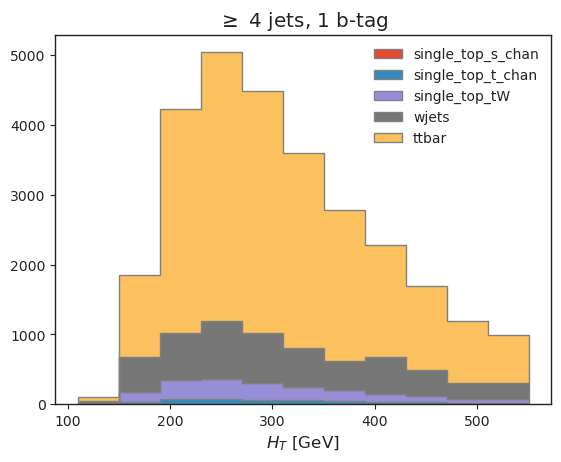

In [9]:
utils.plotting.set_style()

all_histograms["hist_dict"]["4j1b"][120j::hist.rebin(2), :, "nominal"].stack("process")[::-1].plot(stack=True, histtype="fill", linewidth=1, edgecolor="grey")
plt.legend(frameon=False)
plt.title("$\geq$ 4 jets, 1 b-tag")
plt.xlabel("$H_T$ [GeV]");

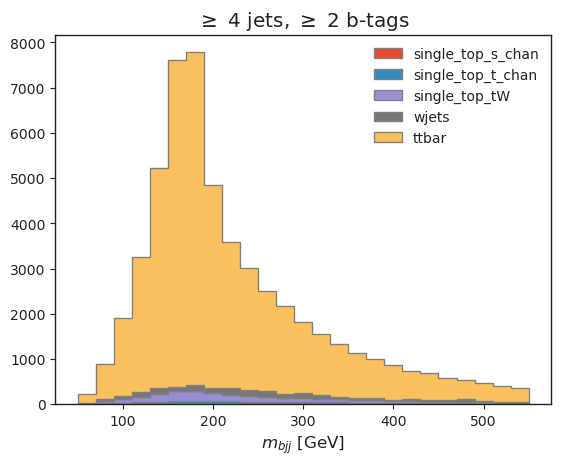

In [10]:
all_histograms["hist_dict"]["4j2b"][:, :, "nominal"].stack("process")[::-1].plot(stack=True, histtype="fill", linewidth=1,edgecolor="grey")
plt.legend(frameon=False)
plt.title("$\geq$ 4 jets, $\geq$ 2 b-tags")
plt.xlabel("$m_{bjj}$ [GeV]");

Our top reconstruction approach ($bjj$ system with largest $p_T$) has worked!

Let's also have a look at some systematic variations:
- b-tagging, which we implemented as jet-kinematic dependent event weights,
- jet energy variations, which vary jet kinematics, resulting in acceptance effects and observable changes.

We are making of [UHI](https://uhi.readthedocs.io/) here to re-bin.

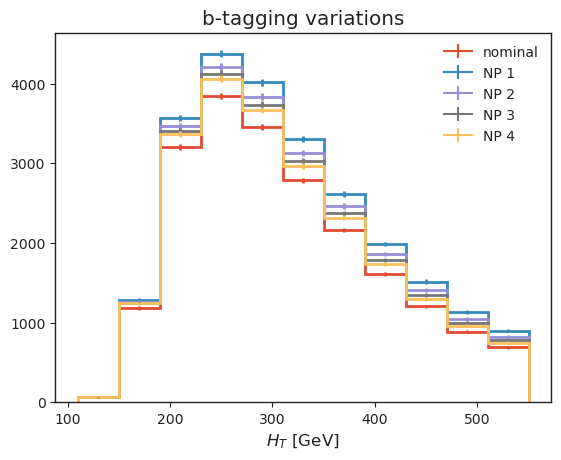

In [11]:
# b-tagging variations
all_histograms["hist_dict"]["4j1b"][120j::hist.rebin(2), "ttbar", "nominal"].plot(label="nominal", linewidth=2)
all_histograms["hist_dict"]["4j1b"][120j::hist.rebin(2), "ttbar", "btag_var_0_up"].plot(label="NP 1", linewidth=2)
all_histograms["hist_dict"]["4j1b"][120j::hist.rebin(2), "ttbar", "btag_var_1_up"].plot(label="NP 2", linewidth=2)
all_histograms["hist_dict"]["4j1b"][120j::hist.rebin(2), "ttbar", "btag_var_2_up"].plot(label="NP 3", linewidth=2)
all_histograms["hist_dict"]["4j1b"][120j::hist.rebin(2), "ttbar", "btag_var_3_up"].plot(label="NP 4", linewidth=2)
plt.legend(frameon=False)
plt.xlabel("$H_T$ [GeV]")
plt.title("b-tagging variations");

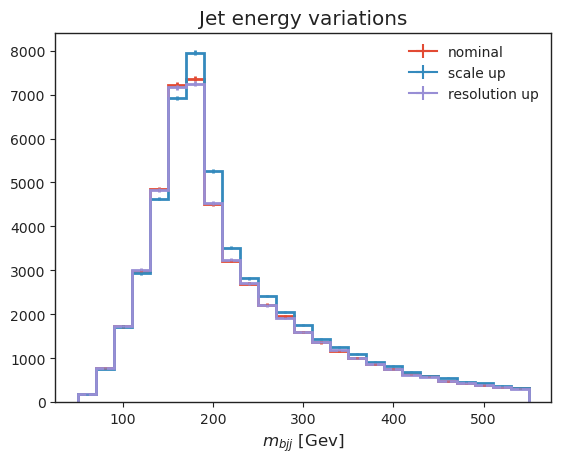

In [12]:
# jet energy scale variations
all_histograms["hist_dict"]["4j2b"][:, "ttbar", "nominal"].plot(label="nominal", linewidth=2)
all_histograms["hist_dict"]["4j2b"][:, "ttbar", "pt_scale_up"].plot(label="scale up", linewidth=2)
all_histograms["hist_dict"]["4j2b"][:, "ttbar", "pt_res_up"].plot(label="resolution up", linewidth=2)
plt.legend(frameon=False)
plt.xlabel("$m_{bjj}$ [Gev]")
plt.title("Jet energy variations");

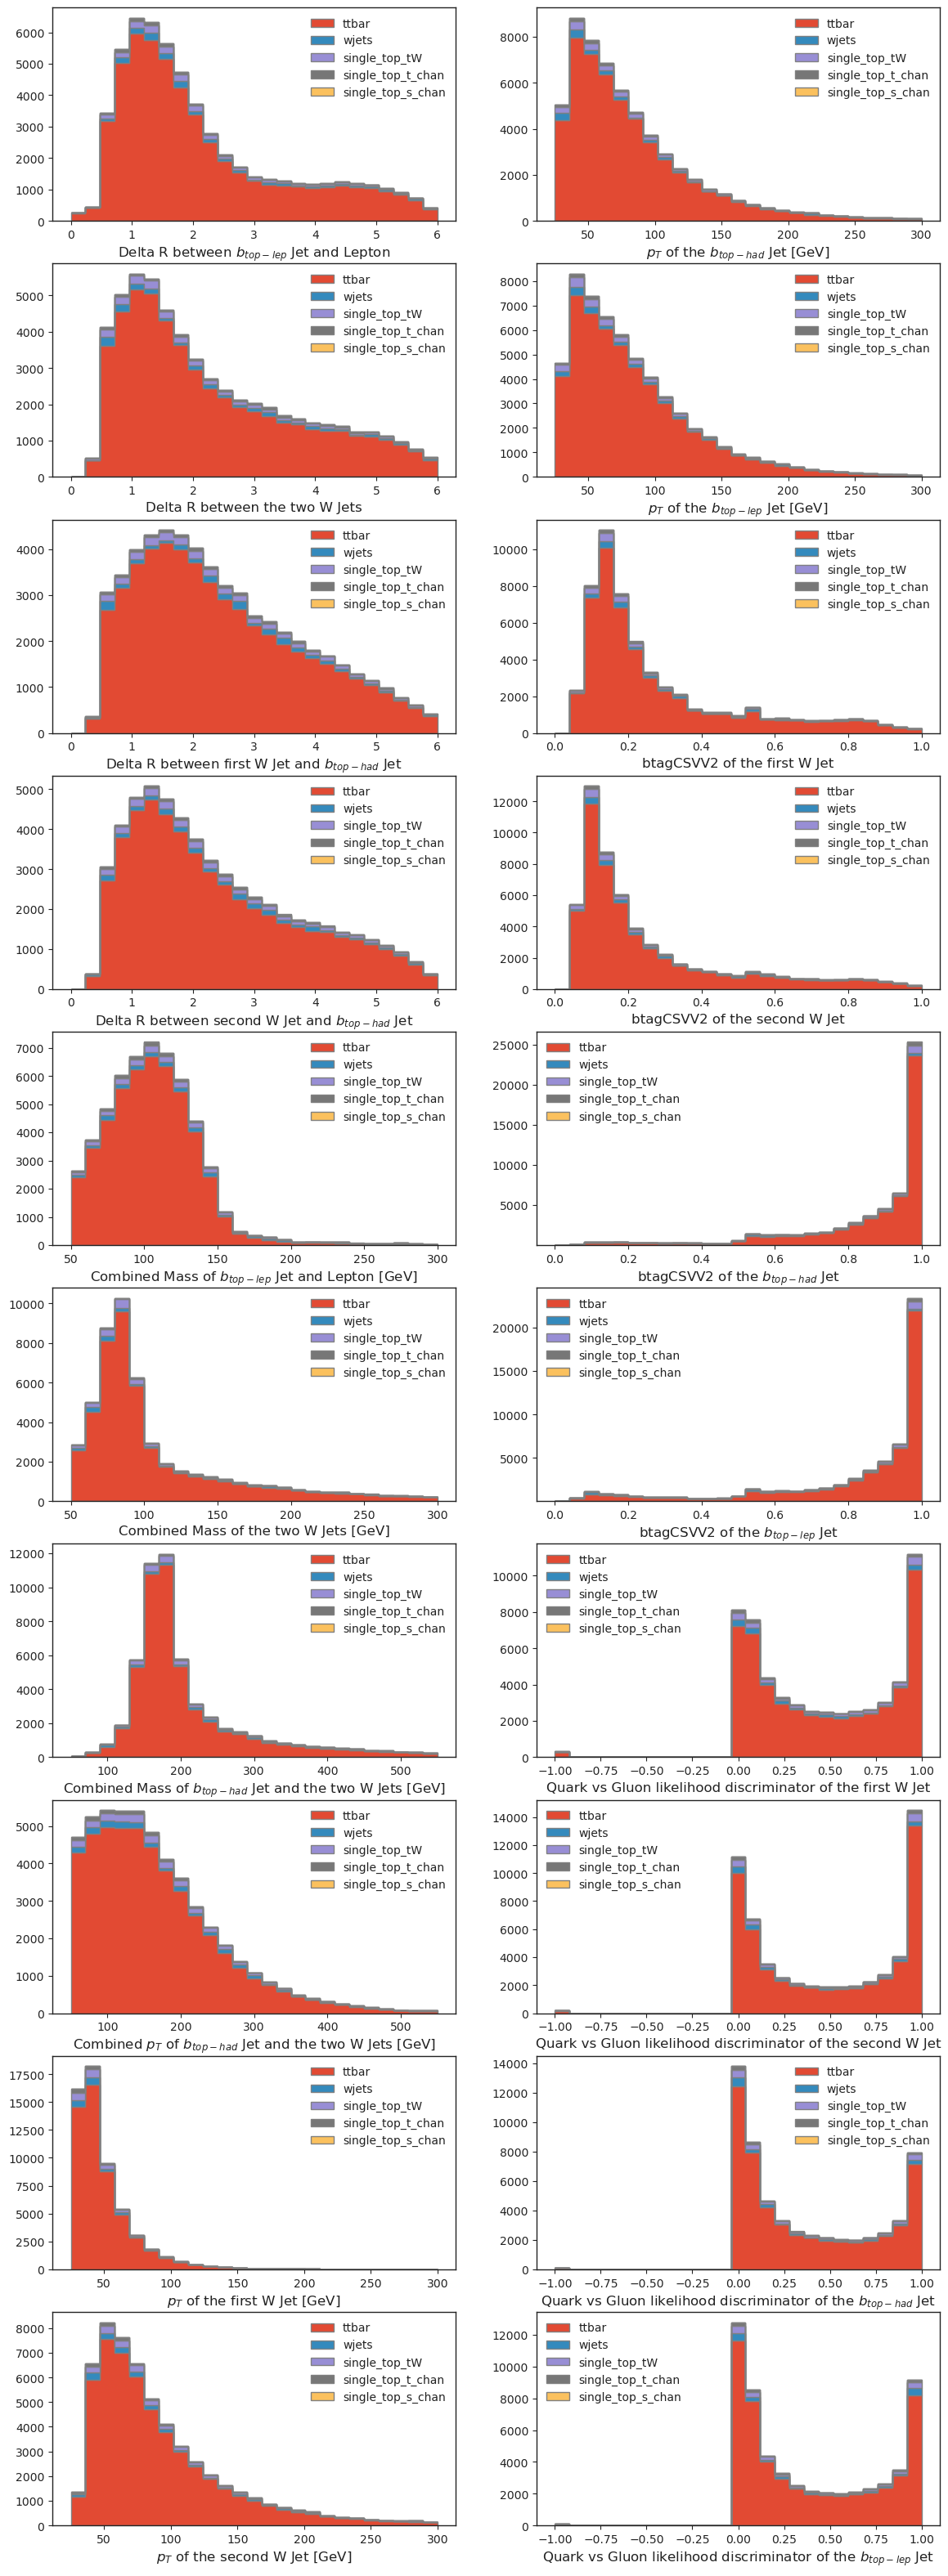

In [13]:
# ML inference variables
if USE_INFERENCE:
    fig, axs = plt.subplots(10,2,figsize=(14,40))
    for i in range(len(utils.config["ml"]["FEATURE_NAMES"])):
        if i<10: 
            column=0
            row=i
        else: 
            column=1
            row=i-10
        all_histograms['ml_hist_dict'][utils.config["ml"]["FEATURE_NAMES"][i]][:, :, "nominal"].stack("process").project("observable").plot(
            stack=True, 
            histtype="fill", 
            linewidth=1, 
            edgecolor="grey", 
            ax=axs[row,column]
        )
        axs[row, column].legend(frameon=False)
    fig.show()

### Save histograms to disk

We'll save everything to disk for subsequent usage.
This also builds pseudo-data by combining events from the various simulation setups we have processed.

In [14]:
utils.file_output.save_histograms(all_histograms['hist_dict'],
                                  fileset,
                                  "histograms.root",
                                  ["4j1b", "4j2b"])
if USE_INFERENCE:
    utils.file_output.save_histograms(all_histograms['ml_hist_dict'],
                                      fileset,
                                      "histograms_ml.root",
                                      utils.config["ml"]["FEATURE_NAMES"],
                                      add_offset=True)

### Statistical inference

We are going to perform a re-binning for the statistical inference.
This is planned to be conveniently provided via cabinetry (see [cabinetry#412](https://github.com/scikit-hep/cabinetry/issues/412), but in the meantime we can achieve this via [template building overrides](https://cabinetry.readthedocs.io/en/latest/advanced.html#overrides-for-template-building).
The implementation is provided in a function in `utils/`.

A statistical model has been defined in `config.yml`, ready to be used with our output.
We will use `cabinetry` to combine all histograms into a `pyhf` workspace and fit the resulting statistical model to the pseudodata we built.

In [15]:
cabinetry_config = cabinetry.configuration.load("cabinetry_config.yml")

# rebinning: lower edge 110 GeV, merge bins 2->1
rebinning_router = utils.rebinning.get_cabinetry_rebinning_router(cabinetry_config, rebinning=slice(110j, None, hist.rebin(2)))
cabinetry.templates.build(cabinetry_config, router=rebinning_router)
cabinetry.templates.postprocess(cabinetry_config)  # optional post-processing (e.g. smoothing)
ws = cabinetry.workspace.build(cabinetry_config)
cabinetry.workspace.save(ws, "workspace.json")

We can inspect the workspace with `pyhf`, or use `pyhf` to perform inference.

In [16]:
!pyhf inspect workspace.json | head -n 20

                  Summary       
            ------------------  
               channels  2
                samples  5
             parameters  14
              modifiers  14

               channels  nbins
             ----------  -----
                4j1b CR   11  
                4j2b SR   11  

                samples
             ----------
                 W+jets
  single top, s-channel
  single top, t-channel
                     tW
                  ttbar



Let's try out what we built: the next cell will perform a maximum likelihood fit of our statistical model to the pseudodata we built.

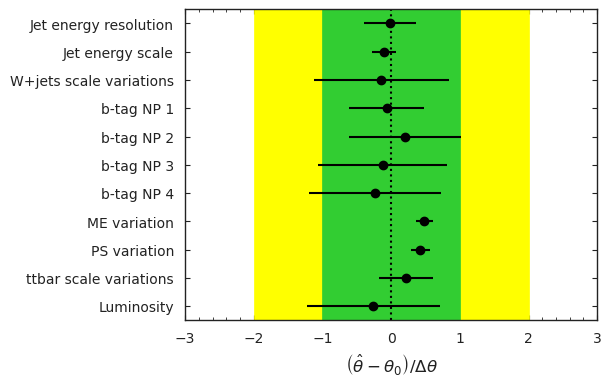

In [17]:
model, data = cabinetry.model_utils.model_and_data(ws)
fit_results = cabinetry.fit.fit(model, data)

cabinetry.visualize.pulls(
    fit_results, exclude="ttbar_norm", close_figure=True, save_figure=False
)

For this pseudodata, what is the resulting ttbar cross-section divided by the Standard Model prediction?

In [18]:
poi_index = model.config.poi_index
print(f"\nfit result for ttbar_norm: {fit_results.bestfit[poi_index]:.3f} +/- {fit_results.uncertainty[poi_index]:.3f}")


fit result for ttbar_norm: 0.961 +/- 0.090


Let's also visualize the model before and after the fit, in both the regions we are using.
The binning here corresponds to the binning used for the fit.

[{'figure': <Figure size 1200x600 with 4 Axes>, 'region': '4j1b CR'},
 {'figure': <Figure size 1200x600 with 4 Axes>, 'region': '4j2b SR'}]

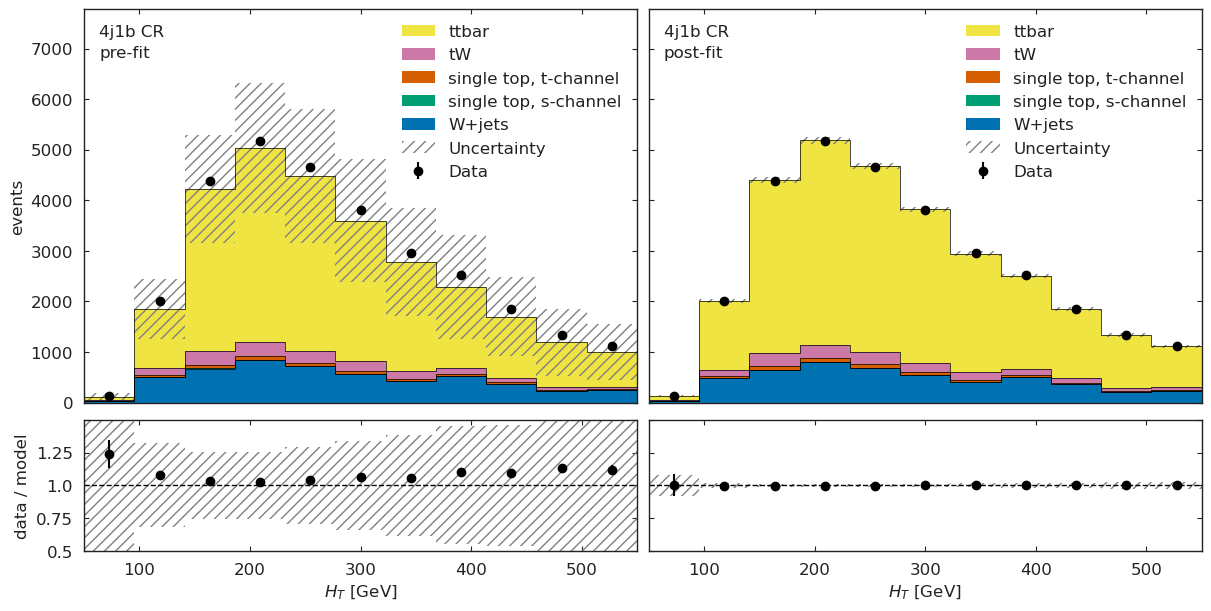

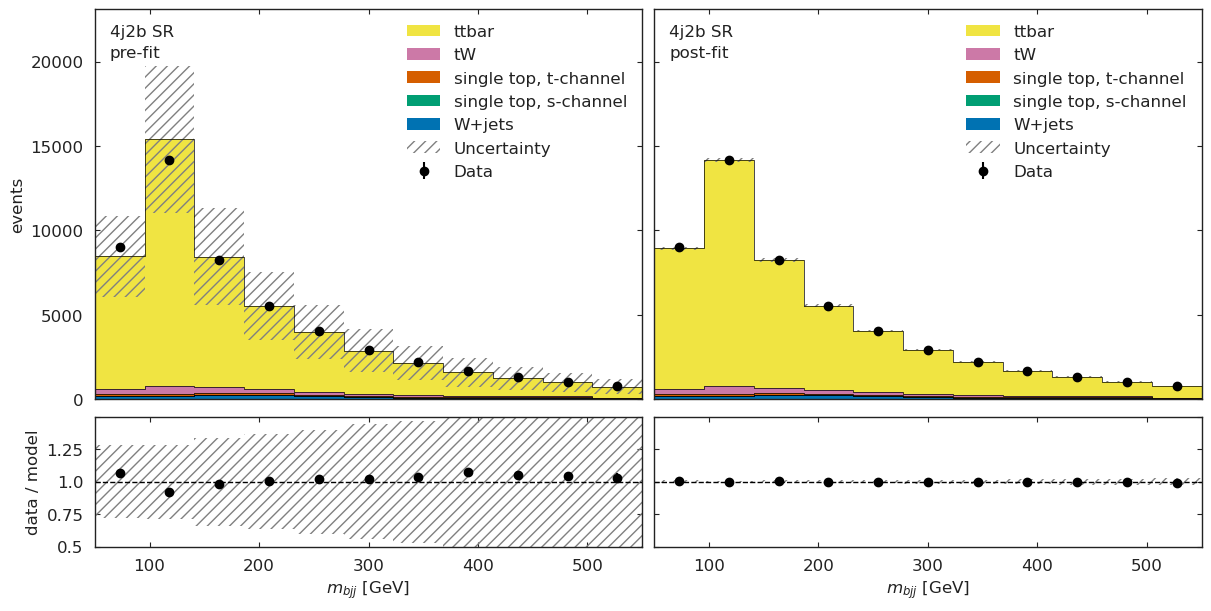

In [19]:
model_prediction = cabinetry.model_utils.prediction(model)
model_prediction_postfit = cabinetry.model_utils.prediction(model, fit_results=fit_results)
figs = cabinetry.visualize.data_mc(model_prediction, data, close_figure=True, config=cabinetry_config)
# below method reimplements this visualization in a grid view
utils.plotting.plot_data_mc(model_prediction, model_prediction_postfit, data, cabinetry_config)

### ML Validation
We can further validate our results by applying the above fit to different ML observables and checking for good agreement.

In [20]:
# load the ml workspace (uses the ml observable instead of previous method)
if USE_INFERENCE:
    config_ml = cabinetry.configuration.load("cabinetry_config_ml.yml")
    cabinetry.templates.collect(config_ml)
    cabinetry.templates.postprocess(config_ml)  # optional post-processing (e.g. smoothing)

    ws_ml = cabinetry.workspace.build(config_ml)
    ws_pruned = pyhf.Workspace(ws_ml).prune(channels=["Feature3", "Feature8", "Feature9",
                                                      "Feature10", "Feature11", "Feature12",
                                                      "Feature13", "Feature14", "Feature15",
                                                      "Feature16", "Feature17", "Feature18",
                                                      "Feature19"])

    cabinetry.workspace.save(ws_pruned, "workspace_ml.json")

In [21]:
if USE_INFERENCE:
    model_ml, data_ml = cabinetry.model_utils.model_and_data(ws_pruned)

We have a channel for each ML observable:

In [22]:
!pyhf inspect workspace_ml.json | head -n 20

                  Summary       
            ------------------  
               channels  7
                samples  5
             parameters  19
              modifiers  19

               channels  nbins
             ----------  -----
               Feature0   25  
               Feature1   25  
               Feature2   25  
               Feature4   25  
               Feature5   25  
               Feature6   25  
               Feature7   25  

                samples
             ----------
                 W+jets


In [23]:
# obtain model prediction before and after fit
if USE_INFERENCE:
    model_prediction = cabinetry.model_utils.prediction(model_ml)
    fit_results_mod = cabinetry.model_utils.match_fit_results(model_ml, fit_results)
    model_prediction_postfit = cabinetry.model_utils.prediction(model_ml, fit_results=fit_results_mod)

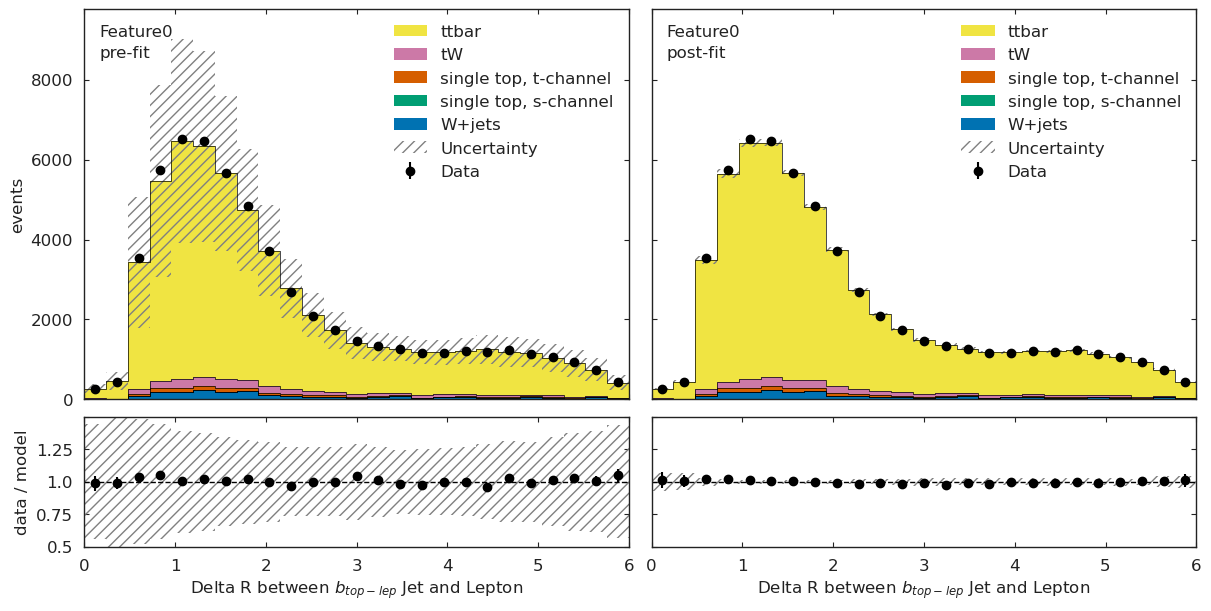

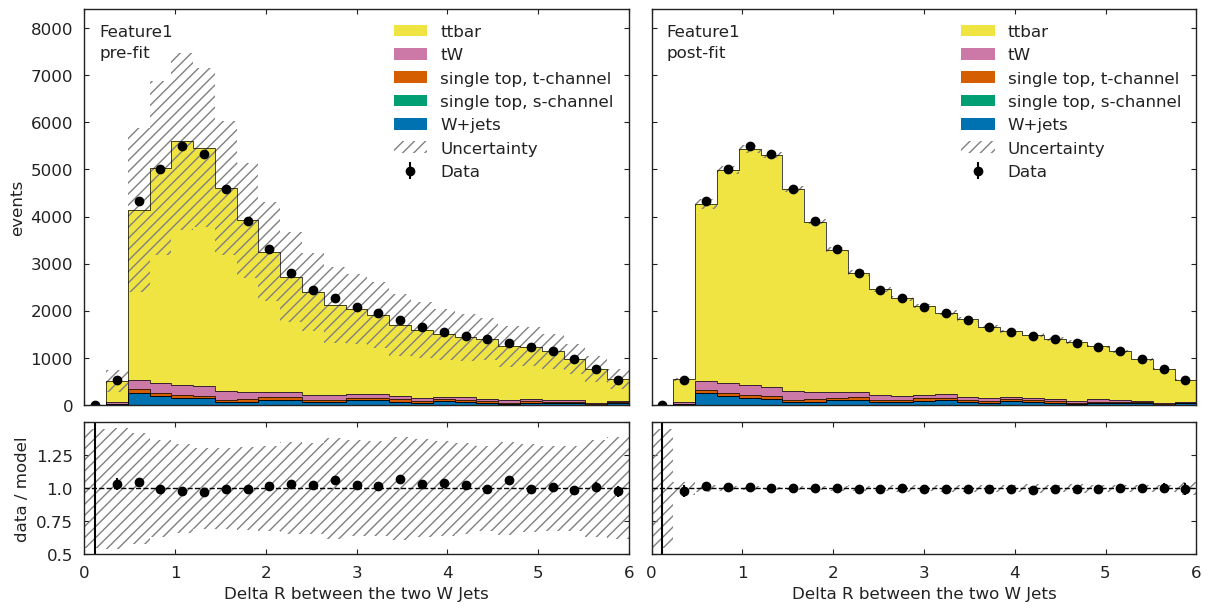

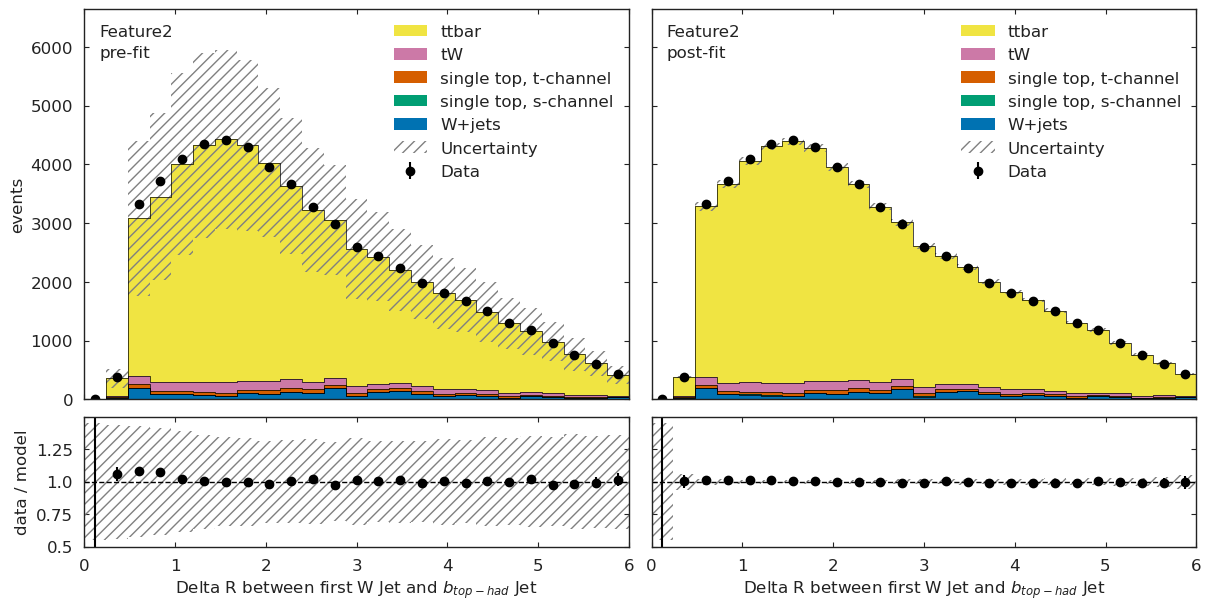

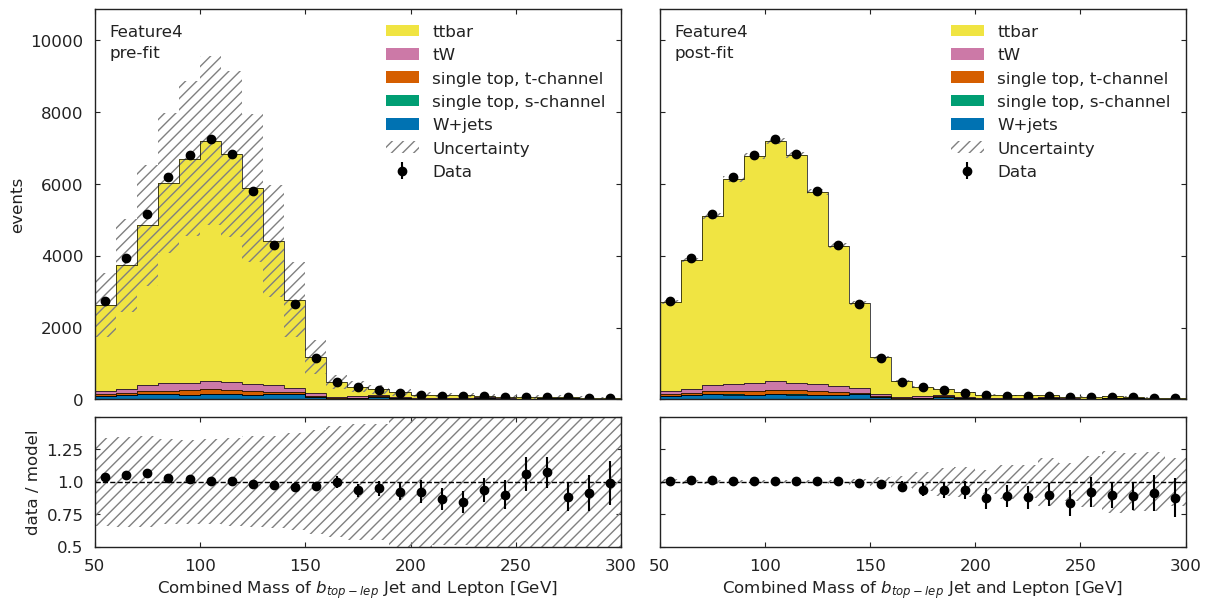

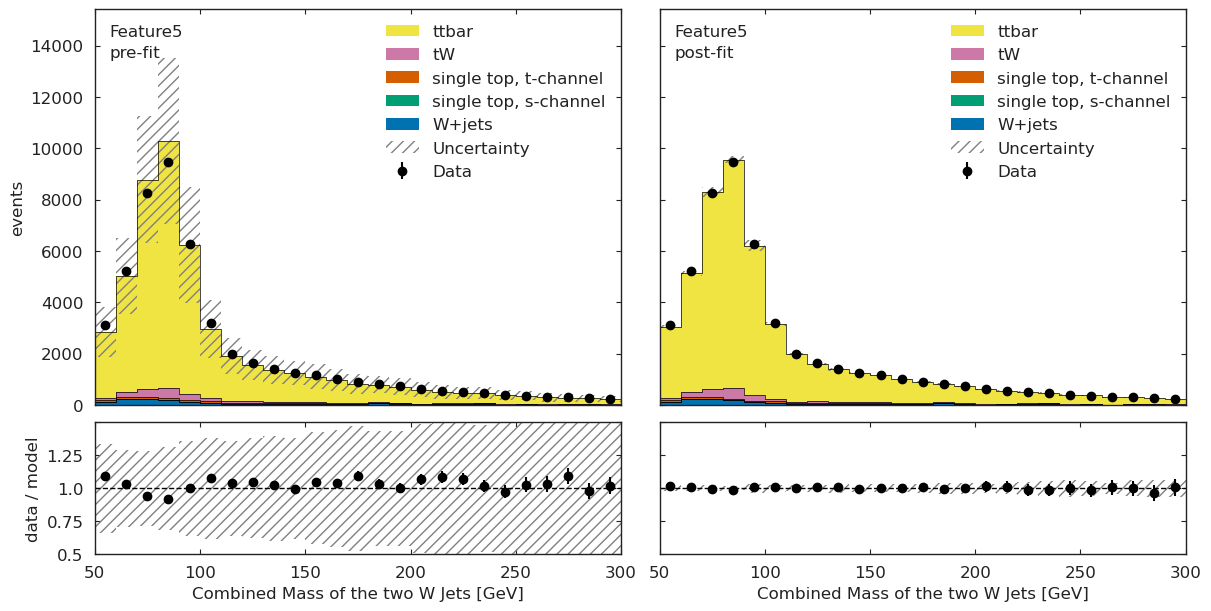

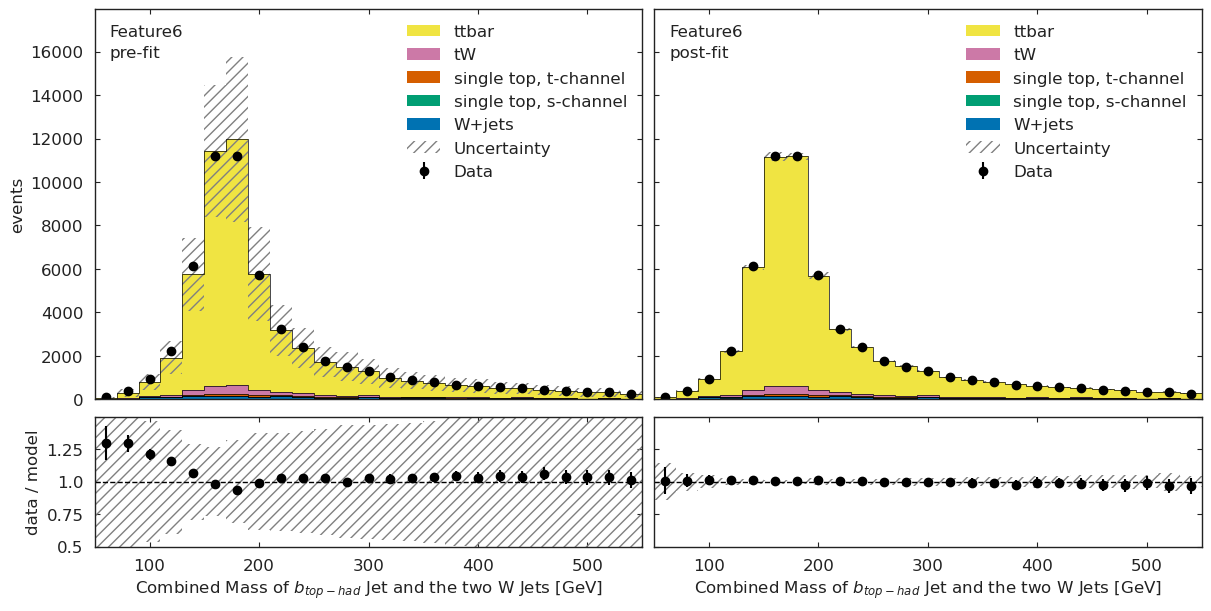

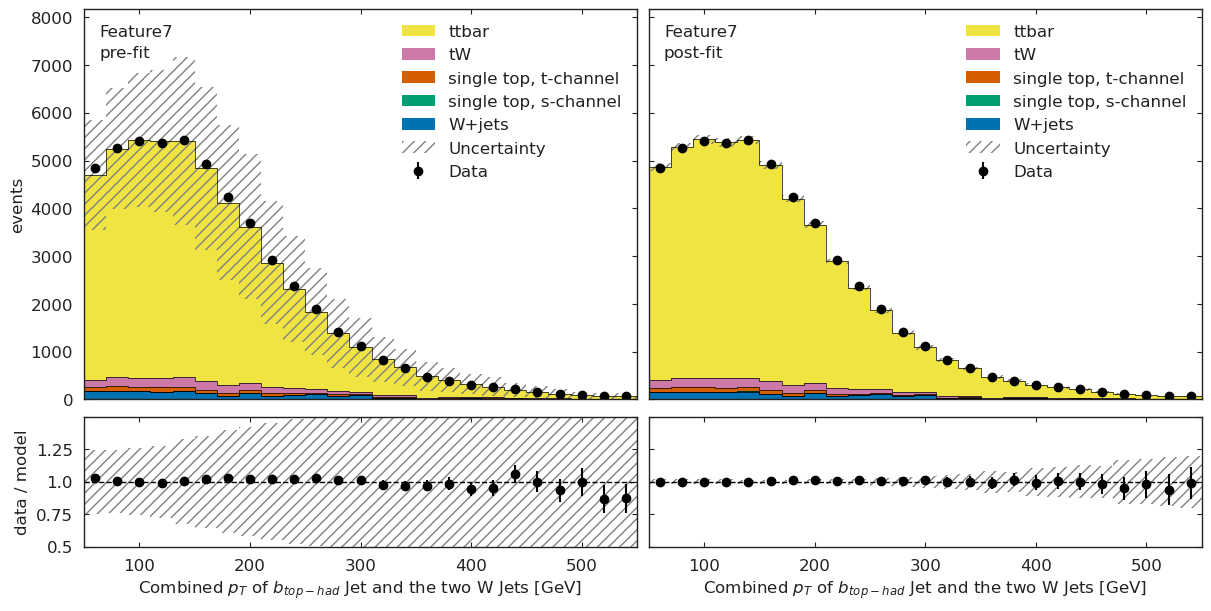

In [24]:
if USE_INFERENCE:
    utils.plotting.plot_data_mc(model_prediction, model_prediction_postfit, data_ml, config_ml)

### What is next?

Our next goals for this pipeline demonstration are:
- making this analysis even **more feature-complete**,
- **addressing performance bottlenecks** revealed by this demonstrator,
- **collaborating** with you!

Please do not hesitate to get in touch if you would like to join the effort, or are interested in re-implementing (pieces of) the pipeline with different tools!

Our mailing list is analysis-grand-challenge@iris-hep.org, sign up via the [Google group](https://groups.google.com/a/iris-hep.org/g/analysis-grand-challenge).